Importing the Data from the Kaggle

In [48]:
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)


2.15.0


In [49]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

40000


Data Manipulation of the accumlated data

In [13]:

# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


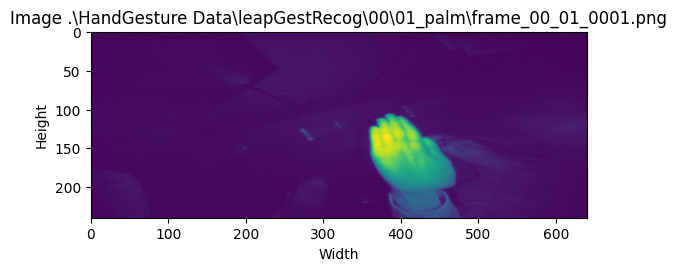

In [14]:
plot_image(imagepaths[0]) #to check the function with our first image

Now We have loaded the images and checked everything if everything is expected, 

(240, 640)


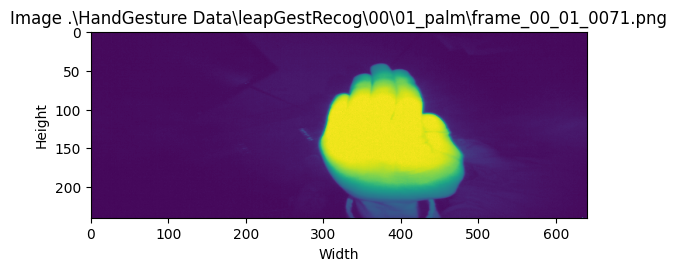

In [15]:
plot_image(imagepaths[70])

In [7]:
print(imagepaths[3])

.\HandGesture Data\leapGestRecog\00\01_palm\frame_00_01_0004.png


In [45]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path
  category = path.split("\\")[4]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging
     

Images loaded:  40000
Labels loaded:  40000
1 .\HandGesture Data\leapGestRecog\00\01_palm\frame_00_01_0001.png


CReating the models

In [57]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)
     

In [64]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout

print(tf.__version__)

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()


2.15.0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 116, 316, 32)      832       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 58, 158, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 156, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 78, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 76, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 38, 64)

Training a Model 

In [65]:
history=model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5


438/438 [==============================] - 419s 951ms/step - loss: 1.2804 - accuracy: 0.5134 - val_loss: 0.8265 - val_accuracy: 0.5337
Epoch 2/5
438/438 [==============================] - 416s 948ms/step - loss: 0.7763 - accuracy: 0.5324 - val_loss: 0.7719 - val_accuracy: 0.5147
Epoch 3/5
438/438 [==============================] - 414s 946ms/step - loss: 0.7342 - accuracy: 0.5384 - val_loss: 0.7482 - val_accuracy: 0.5095
Epoch 4/5
438/438 [==============================] - 417s 950ms/step - loss: 0.7162 - accuracy: 0.5394 - val_loss: 0.7340 - val_accuracy: 0.5125
Epoch 5/5
438/438 [==============================] - 418s 955ms/step - loss: 0.6986 - accuracy: 0.5477 - val_loss: 0.7263 - val_accuracy: 0.5062


In [66]:
model = tf.keras.models.load_model("/content/handrecognition_model.h5")
tf.saved_model.save(model, "tmp_model")
!python -m tf2onnx.convert --saved-model tmp_model --output "handrecognition_model.onnx"
!zip -r /content/tmp_model.zip /content/tmp_model

OSError: No file or directory found at /content/handrecognition_model.h5